In [1]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300

from ts_toolkit.io import clean_timeseries
from ts_toolkit.calendar import add_hour_sin_cos
from ts_toolkit.viz import plot_history_forecast
from ts_toolkit.split import three_way_split
from src.models.direct_catboost_model import DirectDelayForecastModel
from ts_toolkit.metrics import daily_mae
from ts_toolkit.metrics import global_metrics


In [2]:

from src.data_loader import fetch_frame


df = fetch_frame(
    use_cache=True,
    cache_filename="only_common_delayp90.parquet"
)

In [3]:
df = clean_timeseries(df, 'common_delay_p90')   # вместо блока 0‑3


In [4]:
# Разделяем данные
df_train, df_val, df_hold = three_way_split(df, train_ratio=0.8, val_ratio=0.19)

In [5]:
len(df_hold)

907

In [6]:
model = DirectDelayForecastModel(
    horizon=len(df_hold), # Горизонт прогноза равен размеру hold-out
    lags=[1, 2, 4, 96, 192, 5760],
    roll_windows=[4, 96, 192, 1920, 2880, 4320, 5760, 8640],
)

# Обучаем модель. fit больше не возвращает датафреймы.
print("Начинаю обучение модели...")
model.fit(
    train_df=df_train, 
    target_col='common_delay_p90',
    val_df=df_val
    # feature_cols больше не нужны, модель сама создает календарные признаки
)
print("Модель успешно обучена!")
model.save("direct_delay_model_v2") 

Начинаю обучение модели...


Training direct models:   0%|          | 0/907 [00:00<?, ?it/s]

Training complete.
Модель успешно обучена!
Ensemble model saved to direct_delay_model_v2


In [14]:
model

In [80]:
# ── Прогноз на будущее (hold-out) ──────────────────────────
# Для предсказания нам нужна история, достаточная для создания самых "длинных" признаков
history_need = max(model.lags + model.roll_windows)

# Используем только доступную историю (train + val)
# .tail() не нужен, так как _prepare_features сам разберется
# df_context = pd.concat([df_train, df_val])
df_context = df_train[:-9000]

# 🎯 НОВЫЙ МЕТОД ПРОГНОЗА: один вызов возвращает весь горизонт
print("Делаю прогноз...")
y_pred_series = model.predict(df_hist=df_context)
print("Прогноз готов!")

Делаю прогноз...
Прогноз готов!


In [81]:
# Подготавливаем данные для сравнения
pred_idx = y_pred_series.index
y_true = df_train[-9000:]['common_delay_p90'].reindex(y_pred_series.index).dropna()
y_pred = y_pred_series.reindex(y_true.index).dropna() # Убедимся, что все выровнено

print(f"Длина прогноза: {len(y_pred)}, Длина реальных данных: {len(y_true)}")

Длина прогноза: 907, Длина реальных данных: 907


Blind 24-h test • MAE=351.6  RMSE=424.4  MAPE=10.56%  on 907 valid points


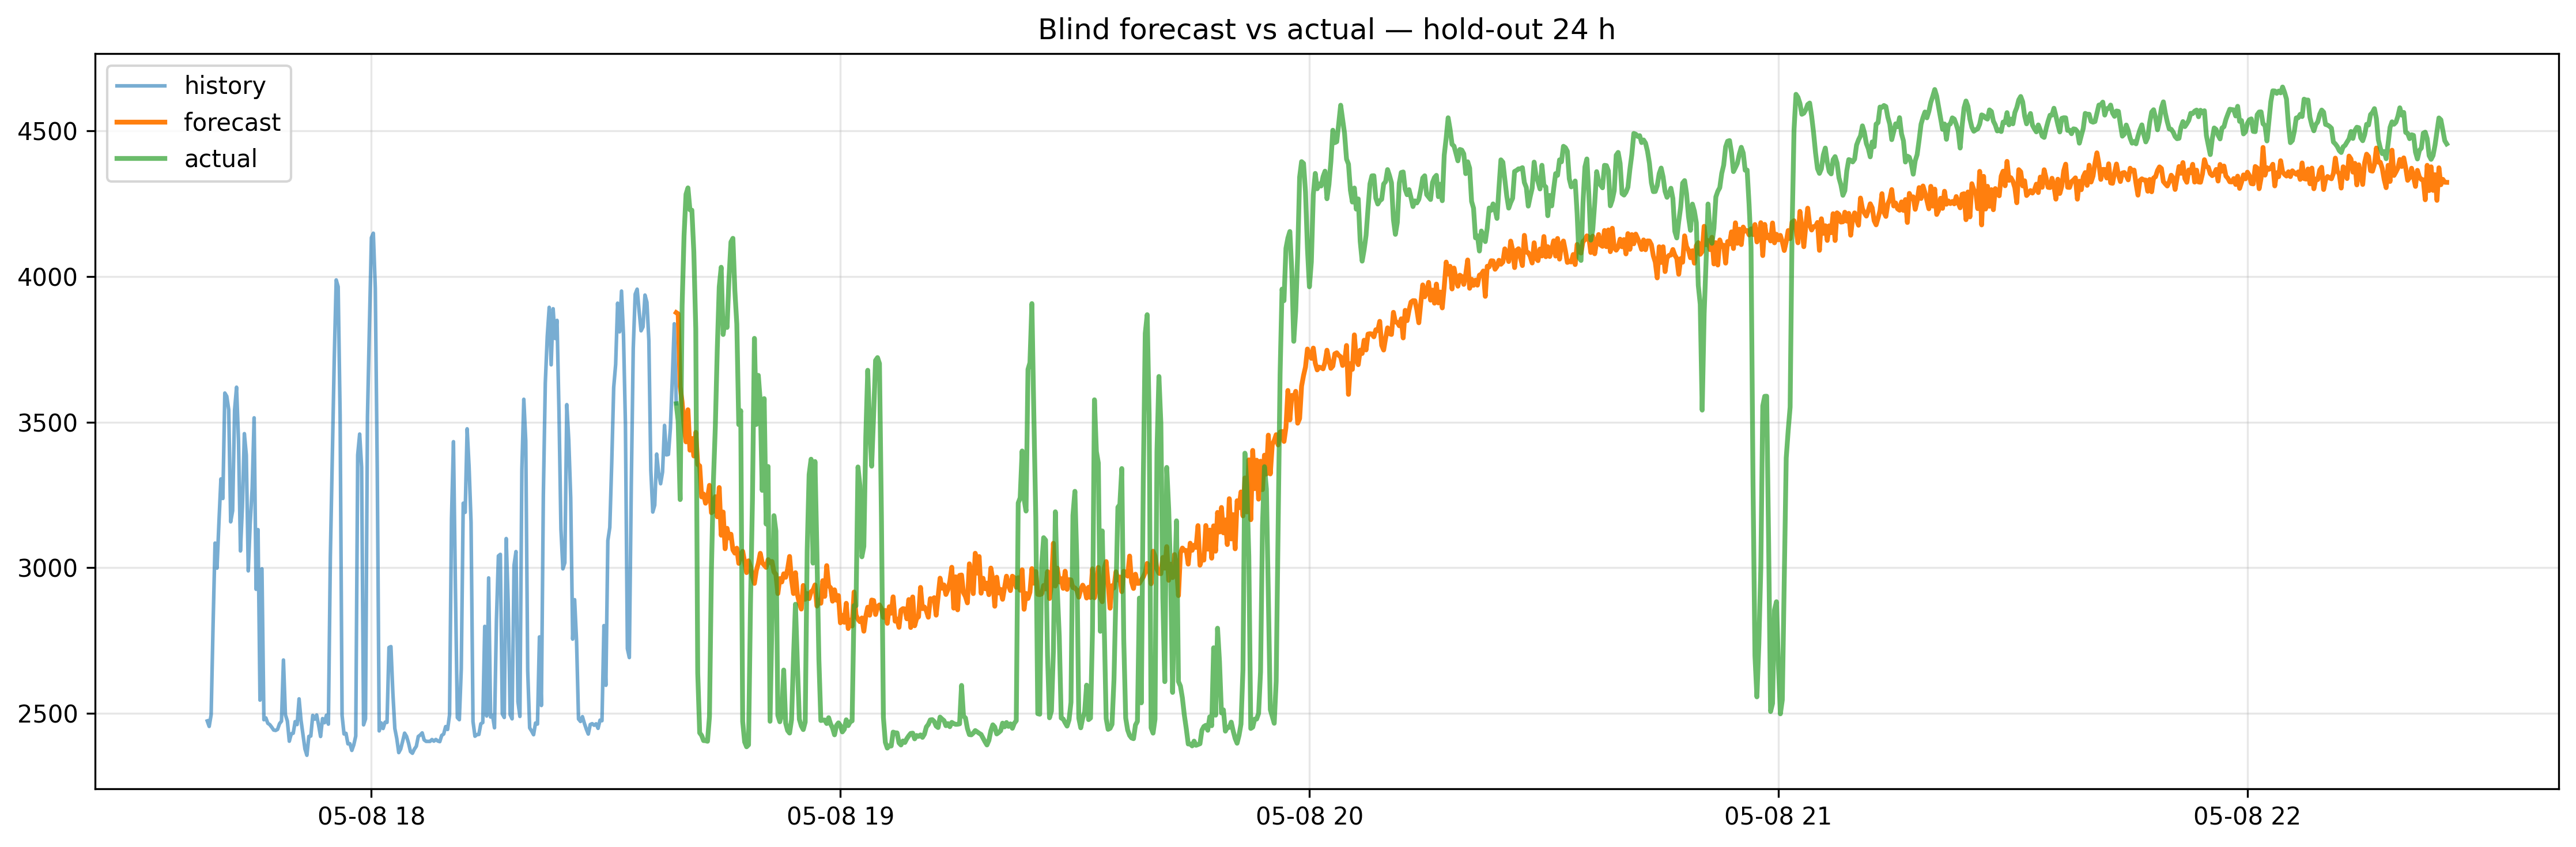

In [82]:
# y_true и y_pred уже созданы в предыдущей ячейке

metrics = global_metrics(y_true, y_pred)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
# hist_start = pred_idx[0] - pd.Timedelta(hours=1)
hist_start = pred_idx[0] - pd.Timedelta(minutes=60)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delay_p90'],
    forecast = pd.Series(y_pred, index=pred_idx),
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)

<Axes: >

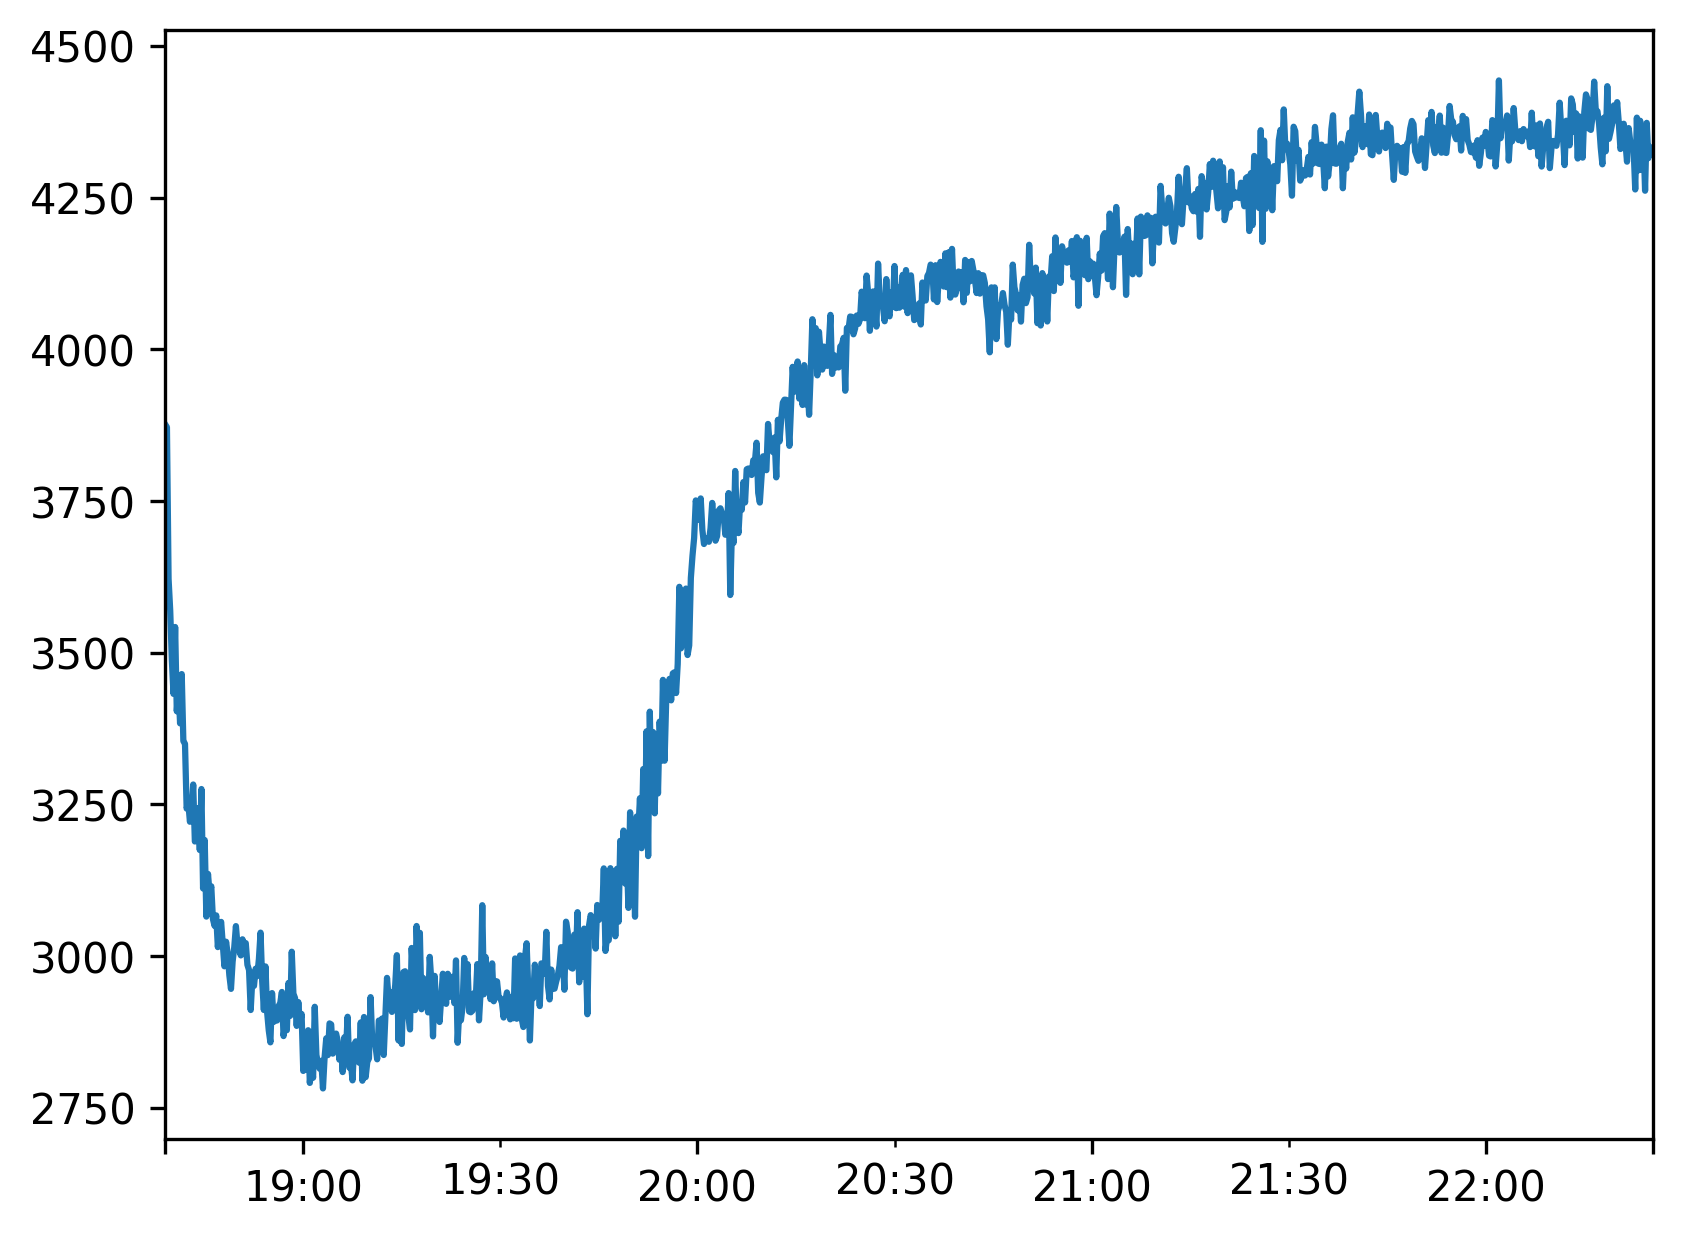

In [83]:
pd.Series(y_pred, index=pred_idx).plot()



*** Hold-out metrics ***
           value
MAE   351.628832
RMSE  424.356254
MAPE   10.559172

MAE by day:
        index         MAE
0  2025-05-08  351.628832


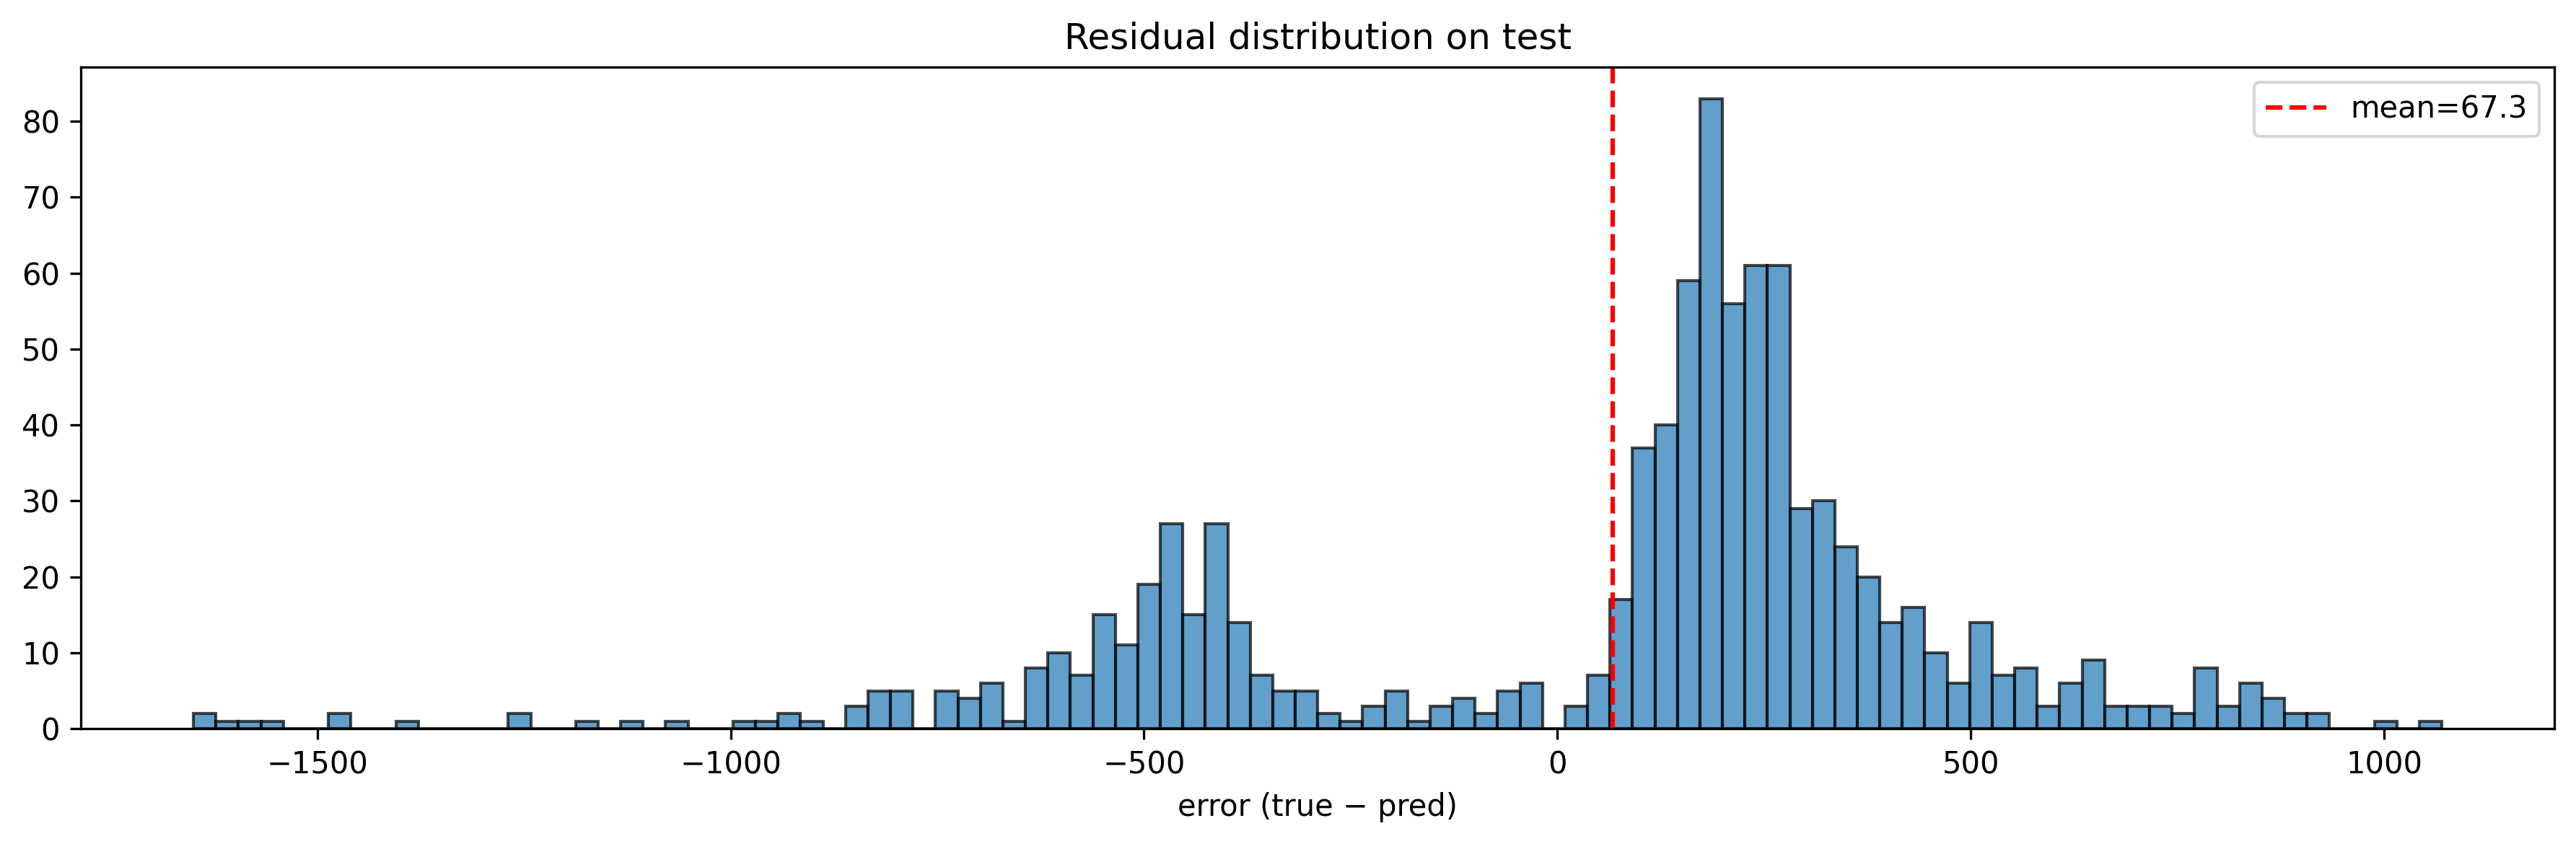

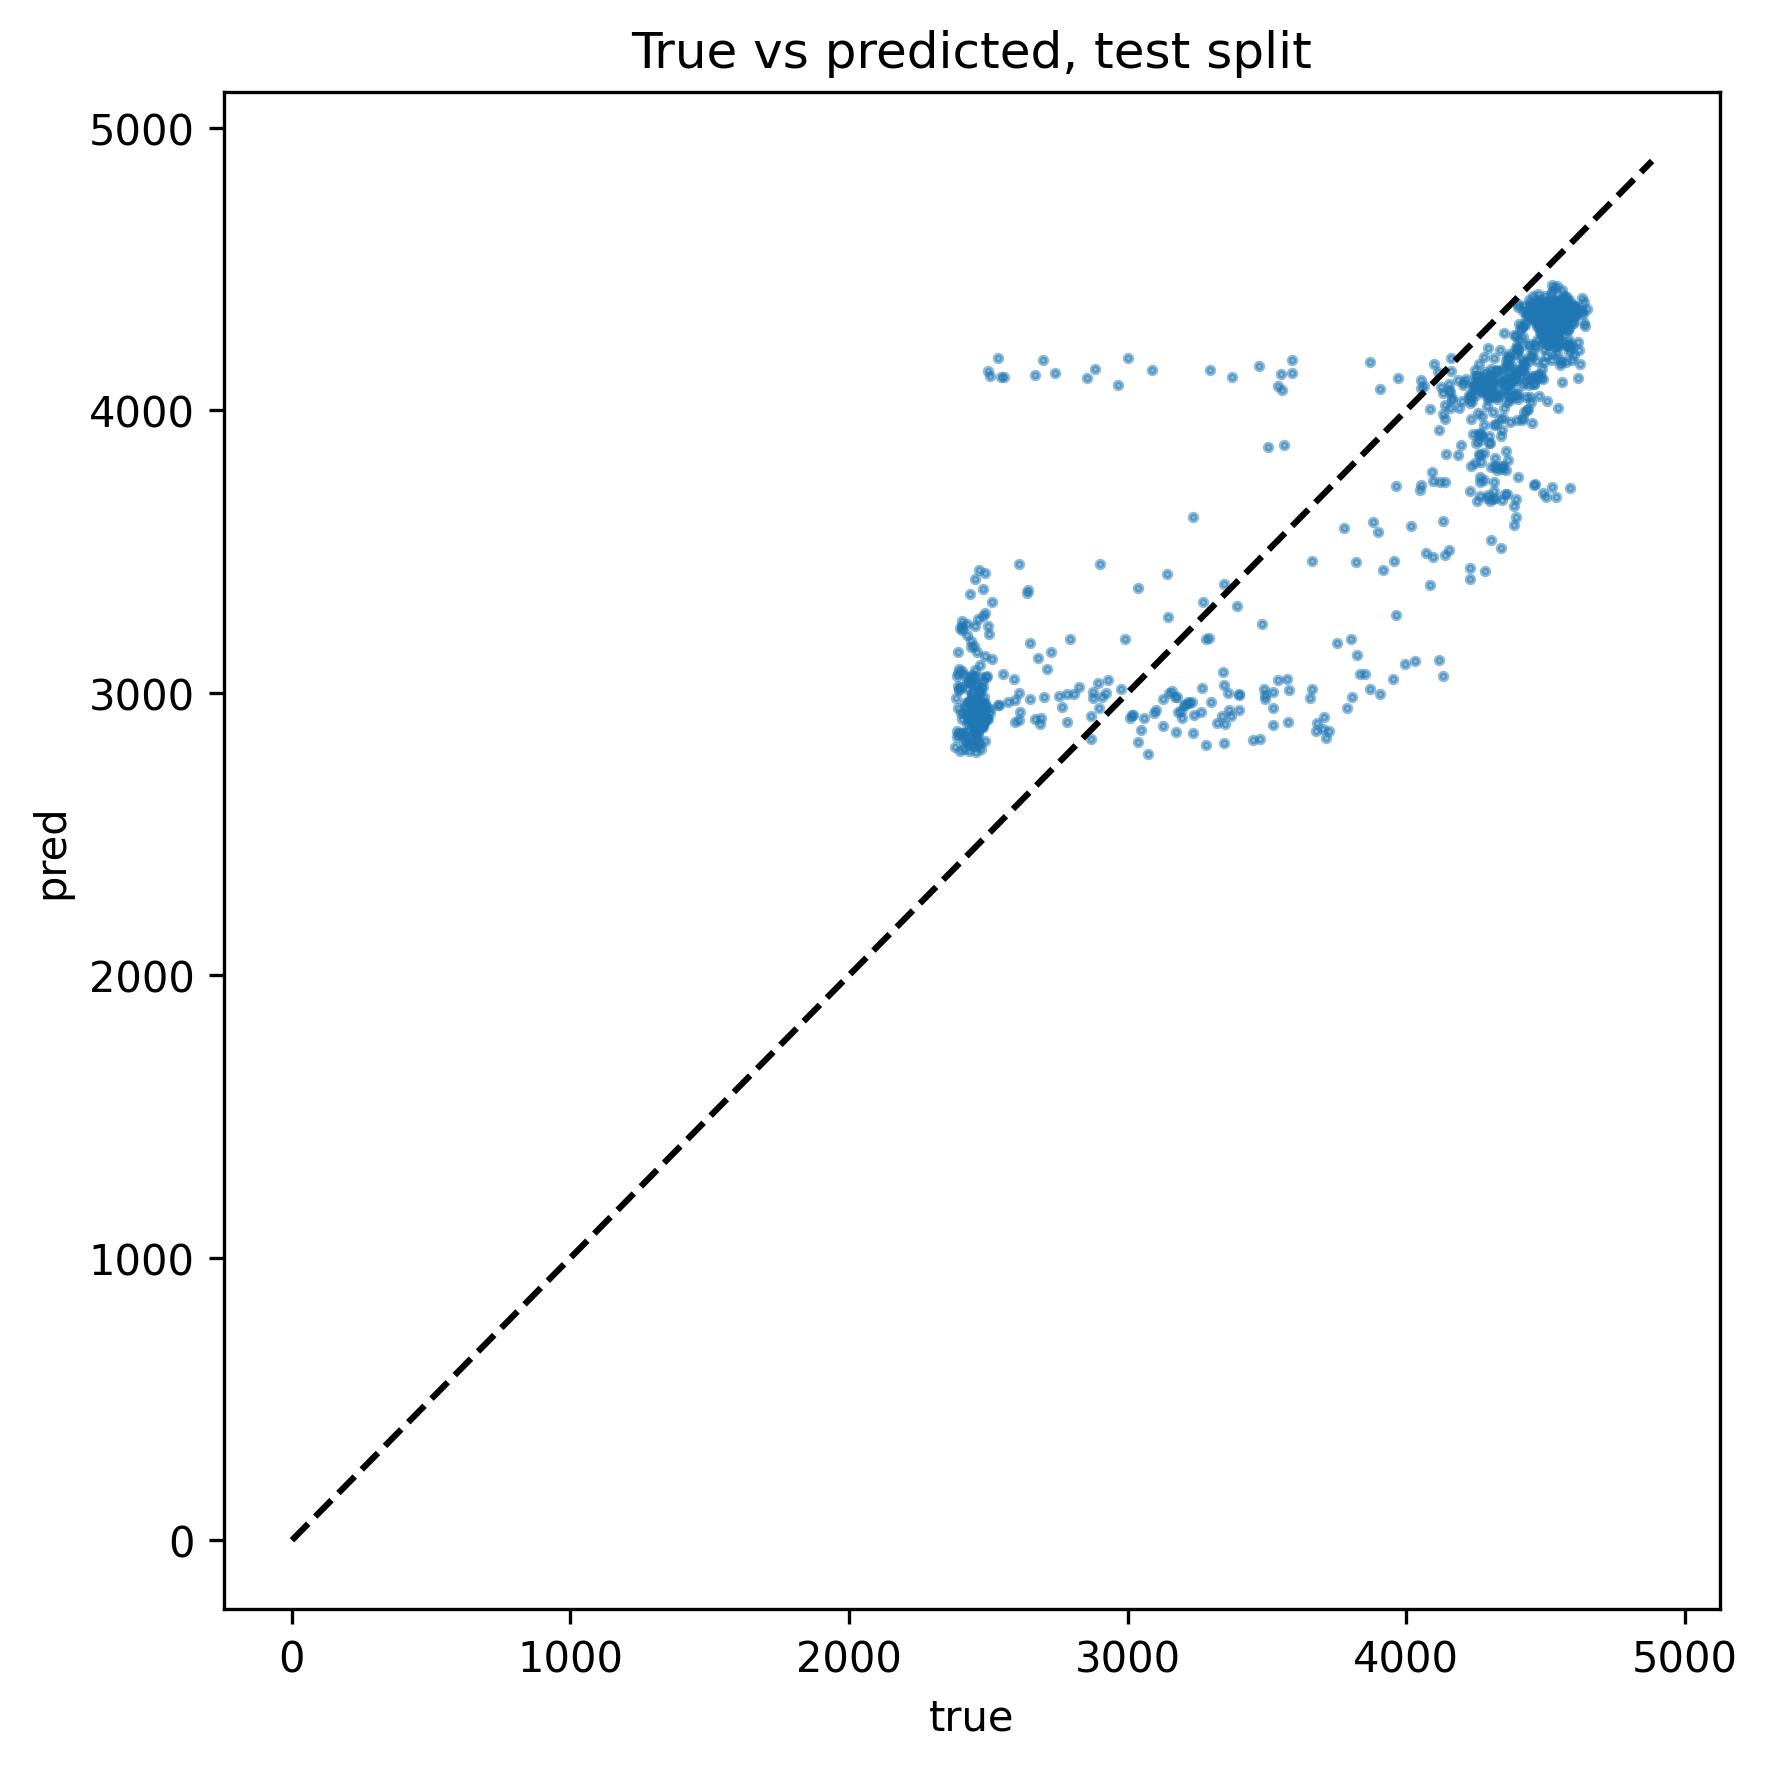

In [84]:
resid = y_true - y_pred


# ---------------------------------------------------
# 2.2  сводные метрики
# ---------------------------------------------------
metrics = global_metrics(y_true, y_pred)
metrics_df = pd.DataFrame([metrics]).T.rename(columns={0: "value"})
print("\n*** Hold-out metrics ***")
print(metrics_df)

# ---------------------------------------------------
# 2.3  метрики по суткам
# ---------------------------------------------------
daily_mae_result = daily_mae(y_true, y_pred)
print("\nMAE by day:")
print(daily_mae_result.tail())

# ---------------------------------------------------
# 2.4  распределение ошибок
# ---------------------------------------------------
plt.figure(figsize=(12,4))
plt.hist(resid, bins=100, alpha=.7, edgecolor='black')
plt.axvline(resid.mean(), color='r', linestyle='--', label=f"mean={resid.mean():.1f}")
plt.title("Residual distribution on test")
plt.xlabel("error (true − pred)")
plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------
# 2.5  true vs pred scatter
# ---------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=3, alpha=0.5)
lim = [0, max(y_true.max(), y_pred.max())*1.05]
plt.plot(lim, lim, 'k--')
plt.xlabel("true"); plt.ylabel("pred")
plt.title("True vs predicted, test split")
plt.tight_layout(); plt.show()


                        feature  importance
0   f_target_ewm_mean_alpha_0_1   23.595647
1   f_target_ewm_mean_alpha_0_3   18.638795
2        common_delay_p90_lag_1    9.364421
3           f_target_roll_max_4    6.992374
4      common_delay_p90_roll_96    5.516561
5          f_target_roll_max_12    5.256170
6     common_delay_p90_roll_192    4.504664
7               f_target_diff_1    4.101418
8        common_delay_p90_lag_2    3.107303
9               f_target_diff_2    2.468650
10      common_delay_p90_roll_4    2.373037
11   f_target_diff_1_roll_std_4    2.299284
12       common_delay_p90_lag_4    1.695780
13   common_delay_p90_roll_1920    1.300210
14              f_target_diff_4    1.166320
15                     hour_cos    1.094694
16   common_delay_p90_roll_2880    0.898006
17      common_delay_p90_lag_96    0.860244
18   common_delay_p90_roll_5760    0.843554
19                     hour_sin    0.842649


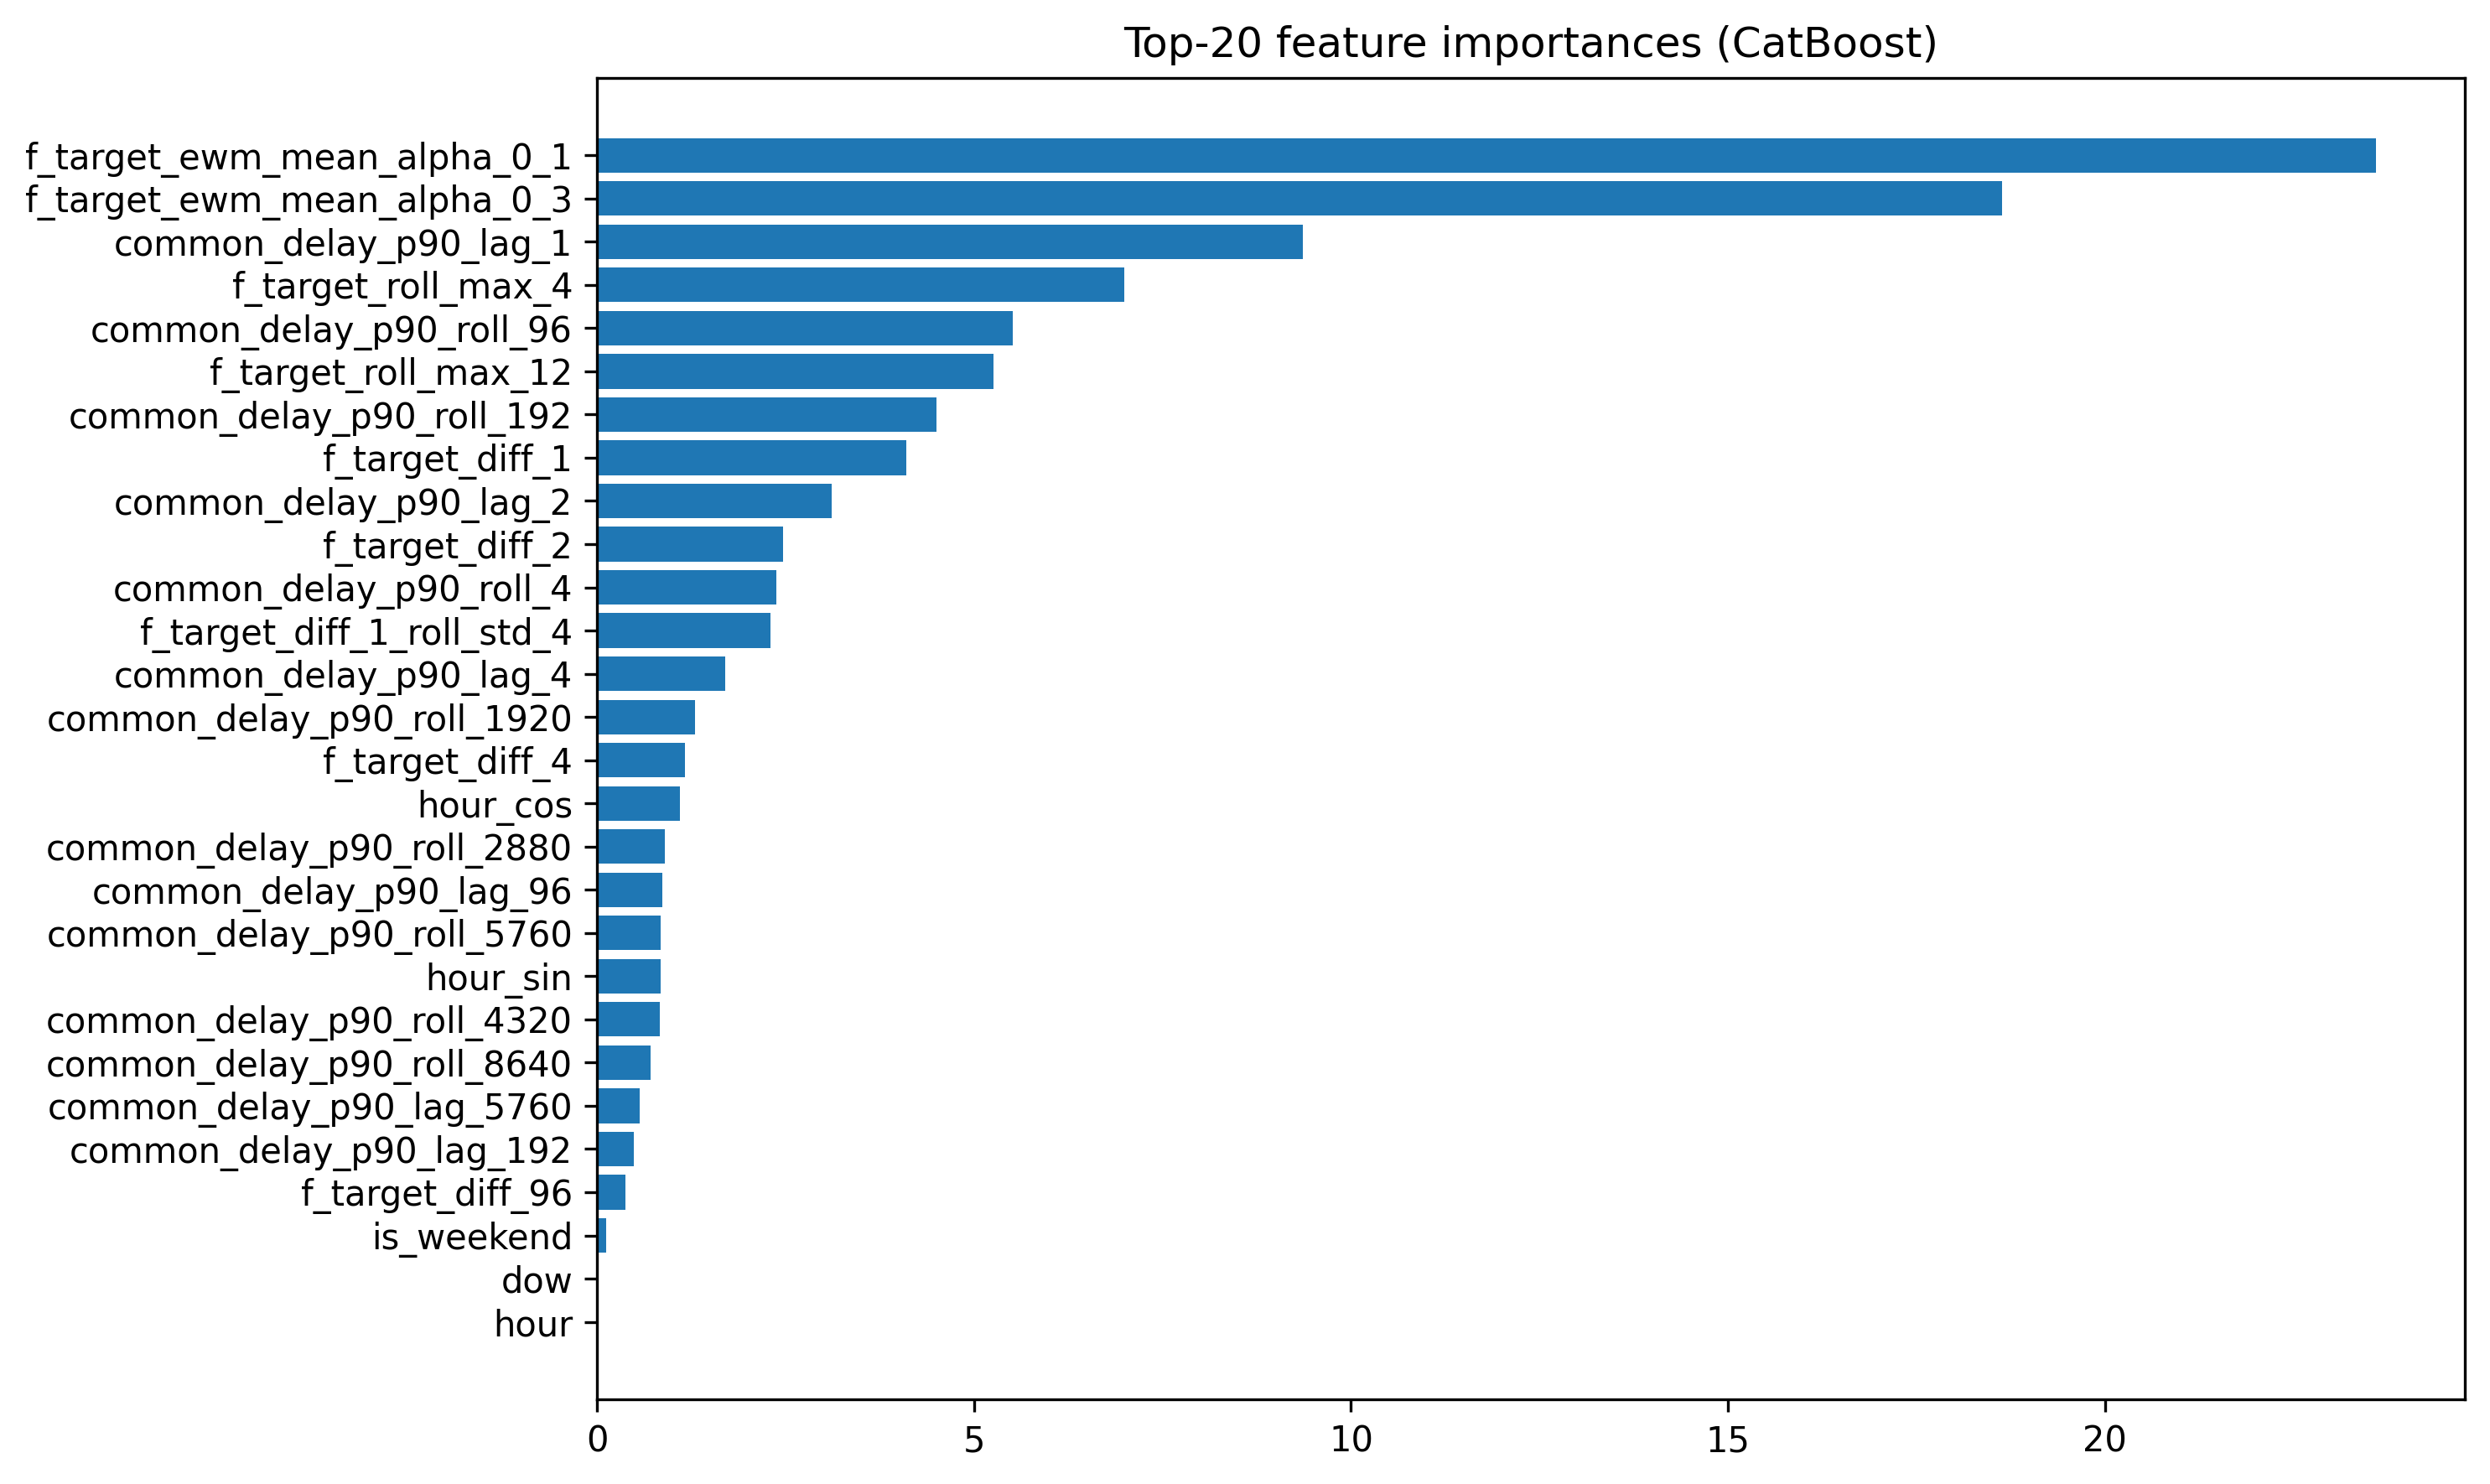

In [87]:
# model = loaded_model
feat_names = model.models[5].feature_names_        # ← то, что CatBoost запомнил
importances = model.models[5].get_feature_importance(type='FeatureImportance')

# в один датафрейм
imp_df = (pd.DataFrame({"feature": feat_names,
                        "importance": importances})
            .sort_values(by="importance", ascending=False)
            .reset_index(drop=True))

print(imp_df.head(20))
# ---------------------------------------------------
#  топ-20 на графике
# ---------------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(imp_df.feature[::-1],
         imp_df.importance[::-1])
# plt.barh(imp_df.feature.head(20)[::-1],
#          imp_df.importance.head(20)[::-1])
plt.title("Top-20 feature importances (CatBoost)")
plt.tight_layout(); plt.show()
